[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/11pjEF8BYzTofnjmkf3kUST56tRwlW1V6#scrollTo=dXUUbvbMTmI-)

# **STORE SALES - TIME SERIES FORECASTING**
Este es un problema de Machine Learning donde se intentan predecir las ventas de ciertas tiendas de la corporación favorita en Ecuador para un periodo de tiempo específico. <br>
Los datos del proyecto se obtienen deste la  competición de Kaggle  [Sales Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data). 

En cuadernos pasados [Data Exploration](https://colab.research.google.com/drive/17Rqvx5LU_KTMkuc75PXgepm7oRePLaYR#scrollTo=xJJSDuil8m2r) y [Análisis](https://colab.research.google.com/drive/1QbxLJz7dDIL4BOG1yaVlum-fndTScgQe) se realizó una exploración de los datos. En este Notebook se usará el módelo **Random Forest Regressor** para la predicción de ventas, se encontrarán los mejores hiperparametros y se graficarán las curvas de aprendizaje

# Librerías a Usar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer


#import seaborn as sns
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#import plotly.express as px 
from itertools import product

from google.colab import files 

# Adquisición de Datos desde Kaggle
Usted puede ejecutar este Notebook sin necesidad de desacrgar los archivos y subirlios. Para eso sóo deberá subir su credencial de Kaggle, para eso:
1. en tu cuenta de kaggle ve a settings -> Create Token
2. Se descargará un archivo ```.json ``` con tus credenciales
3. Ese archivo es el que debes subir cuando al ejecutar el siguiente comando. 

In [2]:
print('Por favor inserte sus credencial se Kaggle, en archivo .json')
files.upload()


Por favor inserte sus credencial se Kaggle, en archivo .json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"felipevasquezu","key":"eb7b2c1020732009b3b57f08a0eacbb3"}'}

## Descargar los Dataset directamente desde Kaggle

In [3]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c store-sales-time-series-forecasting
! unzip store-sales-time-series-forecasting.zip
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 98% 21.0M/21.4M [00:01<00:00, 30.8MB/s]
100% 21.4M/21.4M [00:01<00:00, 19.1MB/s]
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [4]:
path=''
# Load train
train_df = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_df = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
store_df = pd.read_csv(path+'stores.csv')
#Load oil 
oil_df = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_df= pd.read_csv(path+'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Load transactions
transaction_df = pd.read_csv(path+'transactions.csv', parse_dates=['date'], infer_datetime_format=True)

# **Dataset de trabajo**
En esta sección se hara un procesamiento de los datos. Originalmente se poseen las ventas por familia de artículo (33 familias distintas ), por tienda (54 tiendas distintas), por día (desde el ``` 2013-01-01 ``` hasta el ``` 2017-08-15 ```) con un total de $3'000.888$ de filas. Para alcances de este proyecto se analizarán solo la suma de las  ventas por tienda, por día, en las mismas fechas, recogiendo un total de $90.204$ filas. <br>

Las columnas del Dataset construido contiene columnas como: precio del petroleo en ese día ```oil_price``` total de artículos en promoción: ```onpromotion```, total de transacciones de la tienda ```transactions```, determina si el Feriado es a nivel nacional, de estado o de ciudad. <br>

Dada la gran relación que tienen las ventas según las fechas, se han creados otras caracteriticas relacionadas como: día de la semana, año, si es fin de semana, semana del año, mes, si es inicio o fin de mes, si es inicio o fin de año, si es fecha de pago. <br> 

Por último para aplicar las series de tiempo se generan lags para las ventas, transacciones y precio del petroleo. La función diseñada a continuación permite ingresar el número de lags para las 3 instancias anteriores. Según la exploración que se hizo en notebooks anteriores se define 
$lag_{sales}=7 $,     $\;lag_{onpromotion}=3$,   $\; lag_{oil}=3$ 

Formando en total un Dataset de trabajo de $90.204$ filas y $33$ columnas. 


## Funciones para generar Dataset

In [5]:
def create_lags_by_column(df,num_lags,column):
  new_df =  pd.DataFrame(columns=df.columns)
  for y in range(1,55):
    current_df = df[df['store_nbr']== y ]
    for i in range(1,num_lags+1 ):
      current_df[f'lag_{column}_{i}'] = current_df[column].shift(i)

    current_df.dropna(inplace=True)
    current_df.reset_index(inplace=True)
    new_df = pd.concat([new_df, current_df], axis=0, ignore_index=True)
  return new_df

In [6]:
def create_date_features(main_df):
  def get_date_features(df):
    df.loc[:,'day'] = df.date.dt.day
    df.loc[:,'month'] = df.date.dt.month.astype("int8")
    df.loc[:,'day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df.loc[:,'year'] = df.date.dt.year.astype("int32")
    df.loc[:,"is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df.loc[:,'week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df.loc[:,'is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df.loc[:,'is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df.loc[:,'is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df.loc[:,'is_year_end'] = df.date.dt.is_year_end.astype("int8")
    return df
  pd.options.mode.chained_assignment = None
  main_df = get_date_features(main_df)
  main_df.loc[:,"wageday"] = pd.Series(np.where((main_df['is_month_end'] == 1) | (main_df["day"] == 15), 1, 0)).astype("int8")
  return main_df

In [7]:
def create_main_df2(df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags):
  
  def create_holidays(df,holidays):
    #Creando Holidays 

    holiday = holidays[holidays['transferred'] == False].copy()
    holiday.rename(columns = {'type':'holiday_type'},inplace=True)
    holiday.drop(['transferred', 'description'], axis=1, inplace=True)

    #Festivos nacionales ( aplica a todas las tiendas)
    national_holidays = holiday[holiday['locale'] == 'National'][['date','holiday_type']].copy()
    national_holidays.rename(columns = {'holiday_type':'national_holiday_type'},inplace=True)
    national_holidays
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)

    #Festivos de estados 
    state_holidays = holiday[holiday['locale'] == 'Regional'][['date','locale_name','holiday_type']].copy()
    state_holidays.rename(columns = {'locale_name':'state','holiday_type':'state_holiday_type'},inplace=True)
    state_holidays

    #Festivos por ciudad 
    city_holidays = holiday[holiday['locale'] == 'Local'][['date','locale_name','holiday_type']].copy()
    city_holidays.rename(columns = {'locale_name':'city','holiday_type':'city_holiday_type'},inplace=True)

    #Merge
    df = pd.merge(df, national_holidays, how='left', on=['date']) 
    df = pd.merge(df, state_holidays, how='left', on=['date','state']) 
    df = pd.merge(df, city_holidays, how='left', on=['date','city']) 

    #Convirtiendo columnas holidays a binarias 
    df.loc[df['national_holiday_type'].notna(), 'national_holiday_type'] = 1
    df.loc[df['national_holiday_type'].isna(), 'national_holiday_type'] = 0
    df['national_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['state_holiday_type'].notna(), 'state_holiday_type'] = 1
    df.loc[df['state_holiday_type'].isna(), 'state_holiday_type'] = 0
    df['state_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['city_holiday_type'].notna(), 'city_holiday_type'] = 1
    df.loc[df['city_holiday_type'].isna(), 'city_holiday_type'] = 0
    df['city_holiday_type'] =df['national_holiday_type'].astype(int)

    #Eliminado duplicados
    dup = df[['date','store_nbr']].duplicated()
    df.drop(index=df[dup].index,inplace=True)

    return df
  
  def create_oil(df,oil):
    oil_data = oil.copy()
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].rolling(3, min_periods=1).mean())
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data.loc[0,'oil_price']=oil_data.loc[1,'oil_price'] #setting first oil price
    df= pd.merge(df,oil_data,on='date',how='left')
    df['oil_price'].fillna(df['oil_price'].rolling(3, min_periods=1).mean(),inplace=True)
    return df

  df_main = df.copy()
  df_main.drop(['family'],axis=1,inplace=True)
  df_main = df_main.groupby(['date','store_nbr']).sum()[['sales','onpromotion']].reset_index()

  #Date features 
  create_date_features(df_main)

  #Transactions
  df_tran = transaction_df.groupby(['date','store_nbr']).sum().reset_index()
  df_main =  pd.merge(df_main,df_tran, on=['date','store_nbr'],how='left')
  df_main['transactions'].fillna(0,inplace=True)

  #Stores
  df_main = pd.merge(df_main,store_df, on='store_nbr',how='left')
  
  #Holidays
  df_main = create_holidays(df_main,holiday)

  #sorting DF 
  df_main = df_main.sort_values(['store_nbr','date'])

  #Merge Oil
  df_main = create_oil(df_main,oil)


  #Creating Lags 
  if num_sales_lags>0 :
    df_main = create_lags_by_column(df_main,num_sales_lags,'sales')
    df_main = df_main.drop(columns=['index'])
  
  if num_oil_lags>0 :
    df_main = create_lags_by_column(df_main,num_oil_lags,'oil_price')
    df_main = df_main.drop(columns=['index'])
    
  if num_trans_lags>0 :
    df_main = create_lags_by_column(df_main,num_trans_lags,'transactions')
    df_main = df_main.drop(columns=['index'])

  #Deleting unecesary columns
  df_main = df_main.drop(columns=['city','state','cluster','type'])


  return df_main

## Análisis de la Tienda 52
No se tienen registros de ventas de la tienda 52 hasta el ``` 2017-04-20 ```. Es decir faltan registros de ``` sales ``` ``` transactions ``` y ``` onpromotion ``` de esa tienda. Para suplir esta ausencia de datos se propone
- Comparar las ventas en las fechas que se tiene registro con todas las tiendas, y asignarle las ventas de la tienda que más se asemeje
- Comparar las promociones en las fechas que se tiene registro con todas las tiendas, y asignarle las promociones de la tienda que más se asemeje
- Comparar las transacciones en las fechas que se tiene registro con todas las tiendas, y asignarle las transacciones de las tienda que más se asemeje

In [8]:
# GENERAR EL DATASET 
#los parametros en orden son: df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags

main_dataset=create_main_df2(train_df,oil_df,transaction_df,holiday_df,7,3,3)

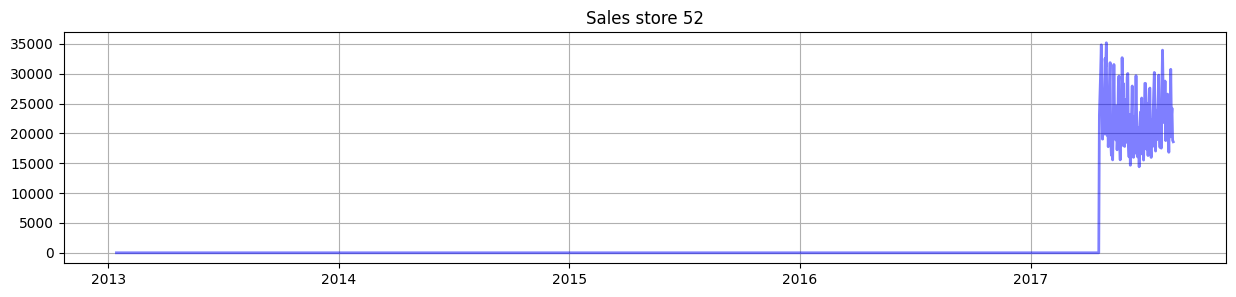

In [9]:
#ANALIZAR LA TIENDA 52

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

main_dataset
data_store52=main_dataset[main_dataset['store_nbr']==52]
data_store52.head(10)

plt.figure(figsize=(15,3))
plt.plot(data_store52['date'], data_store52['sales'], color="blue", lw=2, label="true", alpha=.5)
#plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6)
plt.title("Sales store 52")
plt.grid();

In [10]:
#Fecha en qué empezo a vender la tienda 52: 2017-04-20
data_store52[data_store52['sales']>0].head(5)

,date,store_nbr,sales,onpromotion,day,month,day_of_week,year,is_wknd,week_of_month,...,lag_sales_4,lag_sales_5,lag_sales_6,lag_sales_7,lag_oil_price_1,lag_oil_price_2,lag_oil_price_3,lag_transactions_1,lag_transactions_2,lag_transactions_3
86774,2017-04-20,52,23105.54201,0,20,4,4,2017,0,3,...,0.00000,0.0,0.0,0.0,50.49,52.46,52.62,0.0,0.0,0.0
86775,2017-04-21,52,26493.17200,470,21,4,5,2017,1,3,...,0.00000,0.0,0.0,0.0,50.26,50.49,52.46,4068.0,0.0,0.0
86776,2017-04-22,52,30357.37500,292,22,4,6,2017,1,4,...,0.00000,0.0,0.0,0.0,49.64,50.26,50.49,3151.0,4068.0,0.0
86777,2017-04-23,52,34841.13400,296,23,4,7,2017,1,4,...,0.00000,0.0,0.0,0.0,49.95,49.64,50.26,4046.0,3151.0,4068.0
86778,2017-04-24,52,25718.94300,274,24,4,1,2017,0,4,...,23105.54201,0.0,0.0,0.0,49.64,49.95,49.64,4209.0,4046.0,3151.0


In [11]:
stores=np.arange(1,55)
dif_sales=np.stack((stores,np.zeros(54)),axis=1)
dif_onpromo=np.stack((stores,np.zeros(54)),axis=1)
dif_trans=np.stack((stores,np.zeros(54)),axis=1)

sales_52=data_store52[data_store52['date']>='2017-04-20'].sales.values
onpromo_52=data_store52[data_store52['date']>='2017-04-20'].onpromotion.values
trans_52=data_store52[data_store52['date']>='2017-04-20'].transactions.values

for i in stores:
  data_store_i=main_dataset[main_dataset['store_nbr']==i]

  sales_i=data_store_i[data_store_i['date']>='2017-04-20'].sales.values
  dif_sales[i-1,1]=np.mean(np.abs(sales_52-sales_i))

  onpromo_i=data_store_i[data_store_i['date']>='2017-04-20'].onpromotion.values
  dif_onpromo[i-1,1]=np.mean(np.abs(onpromo_52-onpromo_i))

  trans_i=data_store_i[data_store_i['date']>='2017-04-20'].transactions.values
  dif_trans[i-1,1]=np.mean(np.abs(trans_52-trans_i))


dif_sales=dif_sales[dif_sales[:, 1].argsort()]
dif_onpromo=dif_onpromo[dif_onpromo[:, 1].argsort()]
dif_trans=dif_trans[dif_trans[:, 1].argsort()]


print('Tiendas similares en ventas:')
display(dif_sales.astype(int)[:5])

print('\n Tiendas similares en Promociones:')
display(dif_onpromo.astype(float)[:5])

print('\n Tiendas similares en Transacciones:')
display(dif_trans.astype(int)[:5])

Tiendas similares en ventas:


array([[  52,    0],
       [   8, 2335],
       [  50, 2805],
       [  51, 2986],
       [  11, 4425]])


 Tiendas similares en Promociones:


array([[52.        ,  0.        ],
       [50.        , 16.71186441],
       [ 8.        , 17.90677966],
       [ 6.        , 18.51694915],
       [51.        , 19.66949153]])


 Tiendas similares en Transacciones:


array([[ 52,   0],
       [ 34, 351],
       [ 11, 366],
       [  9, 419],
       [ 24, 444]])

Text(0.5, 1.0, 'Sales')

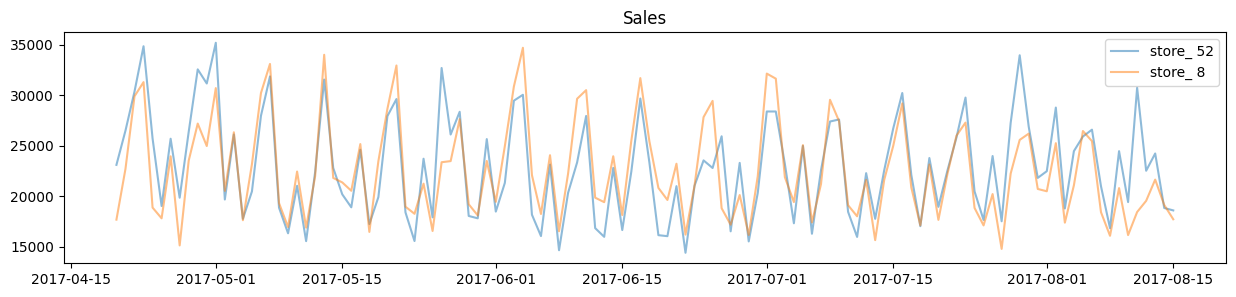

In [12]:
plt.figure(figsize=(15,3))
for i in dif_sales[:2][:,0]:
  store_sales=main_dataset[main_dataset['store_nbr']==i]
  store_sales=store_sales[store_sales['date']>='2017-04-20']
  label='store_ '+str(int(i))
  plt.plot(store_sales['date'], store_sales['sales'], lw=1.5, label=label, alpha=.5)
plt.legend()
plt.title('Sales')

Según los hallazgos anteriores a la tienda 52 en el periodo anterior a 20 de abril de 2017 se le asociarán las ventas de la tienda 8, las promociones de la tienda 50 y las transacciones de la tienda 34

## Regenerar la función para el dataset 

In [13]:
def create_main_df2(df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags):
  
  def create_holidays(df,holidays):
    #Creando Holidays 

    holiday = holidays[holidays['transferred'] == False].copy()
    holiday.rename(columns = {'type':'holiday_type'},inplace=True)
    holiday.drop(['transferred', 'description'], axis=1, inplace=True)

    #Festivos nacionales ( aplica a todas las tiendas)
    national_holidays = holiday[holiday['locale'] == 'National'][['date','holiday_type']].copy()
    national_holidays.rename(columns = {'holiday_type':'national_holiday_type'},inplace=True)
    national_holidays
    national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)

    #Festivos de estados 
    state_holidays = holiday[holiday['locale'] == 'Regional'][['date','locale_name','holiday_type']].copy()
    state_holidays.rename(columns = {'locale_name':'state','holiday_type':'state_holiday_type'},inplace=True)
    state_holidays

    #Festivos por ciudad 
    city_holidays = holiday[holiday['locale'] == 'Local'][['date','locale_name','holiday_type']].copy()
    city_holidays.rename(columns = {'locale_name':'city','holiday_type':'city_holiday_type'},inplace=True)

    #Merge
    df = pd.merge(df, national_holidays, how='left', on=['date']) 
    df = pd.merge(df, state_holidays, how='left', on=['date','state']) 
    df = pd.merge(df, city_holidays, how='left', on=['date','city']) 

    #Convirtiendo columnas holidays a binarias 
    df.loc[df['national_holiday_type'].notna(), 'national_holiday_type'] = 1
    df.loc[df['national_holiday_type'].isna(), 'national_holiday_type'] = 0
    df['national_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['state_holiday_type'].notna(), 'state_holiday_type'] = 1
    df.loc[df['state_holiday_type'].isna(), 'state_holiday_type'] = 0
    df['state_holiday_type'] =df['national_holiday_type'].astype(int)

    df.loc[df['city_holiday_type'].notna(), 'city_holiday_type'] = 1
    df.loc[df['city_holiday_type'].isna(), 'city_holiday_type'] = 0
    df['city_holiday_type'] =df['national_holiday_type'].astype(int)

    #Eliminado duplicados
    dup = df[['date','store_nbr']].duplicated()
    df.drop(index=df[dup].index,inplace=True)

    return df
  
  def create_oil(df,oil):
    oil_data = oil.copy()
    oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(oil_data['dcoilwtico'].rolling(3, min_periods=1).mean())
    oil_data = oil_data.rename(columns={'dcoilwtico': 'oil_price'})
    oil_data.loc[0,'oil_price']=oil_data.loc[1,'oil_price'] #setting first oil price
    df= pd.merge(df,oil_data,on='date',how='left')
    df['oil_price'].fillna(df['oil_price'].rolling(3, min_periods=1).mean(),inplace=True)
    return df

  df_main = df.copy()
  df_main.drop(['family'],axis=1,inplace=True)
  df_main = df_main.groupby(['date','store_nbr']).sum()[['sales','onpromotion']].reset_index()

  #Date features 
  create_date_features(df_main)

  #Transactions
  df_tran = transaction_df.groupby(['date','store_nbr']).sum().reset_index()
  df_main =  pd.merge(df_main,df_tran, on=['date','store_nbr'],how='left')
  df_main['transactions'].fillna(0,inplace=True)

  #Stores
  df_main = pd.merge(df_main,store_df, on='store_nbr',how='left')
  
  #Holidays
  df_main = create_holidays(df_main,holiday)

  #sorting DF 
  df_main = df_main.sort_values(['store_nbr','date'])

  #Merge Oil
  df_main = create_oil(df_main,oil)


  #Corregir los datos de la tienda 52
  sales_8=df_main[(df_main['store_nbr']==8) &(df_main['date']<'2017-04-20')].sales.values
  onpromo_50=df_main[(df_main['store_nbr']==50) & (df_main['date']<'2017-04-20')].onpromotion.values
  trans_34=df_main[(df_main['store_nbr']==34) & (df_main['date']<'2017-04-20')].transactions.values

  df_main['sales'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=sales_8
  df_main['onpromotion'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=onpromo_50
  df_main['transactions'].loc[(df_main['store_nbr']==52) & (df_main['date']<'2017-04-20')]=trans_34


  #Creating Lags 
  if num_sales_lags>0 :
    df_main = create_lags_by_column(df_main,num_sales_lags,'sales')
    df_main = df_main.drop(columns=['index'])
  
  if num_oil_lags>0 :
    df_main = create_lags_by_column(df_main,num_oil_lags,'oil_price')
    df_main = df_main.drop(columns=['index'])
    
  if num_trans_lags>0 :
    df_main = create_lags_by_column(df_main,num_trans_lags,'transactions')
    df_main = df_main.drop(columns=['index'])

  #Deleting unecesary columns
  df_main = df_main.drop(columns=['city','state','cluster','type'])


  return df_main

## Generar Dataset
Basados en la función anterior se genera el Dataset de trabajo 

In [14]:
# los parametros en orden son: df,oil,transaction,holiday,num_sales_lags,num_oil_lags,num_trans_lags

main_dataset=create_main_df2(train_df,oil_df,transaction_df,holiday_df,7,3,3) #Dataset General
main_df_train=main_dataset[main_dataset["date"]<="2017-03-01"]                #Dataset para el train
main_df_test=main_dataset[main_dataset["date"]>"2017-03-01"]                  #Dataset para el test

In [17]:
len(main_df_train), len(main_df_test)

(81216, 9018)

In [16]:
main_dataset.columns

Index(['date', 'store_nbr', 'sales', 'onpromotion', 'day', 'month',
       'day_of_week', 'year', 'is_wknd', 'week_of_month', 'is_month_start',
       'is_month_end', 'is_year_start', 'is_year_end', 'wageday',
       'transactions', 'national_holiday_type', 'state_holiday_type',
       'city_holiday_type', 'oil_price', 'lag_sales_1', 'lag_sales_2',
       'lag_sales_3', 'lag_sales_4', 'lag_sales_5', 'lag_sales_6',
       'lag_sales_7', 'lag_oil_price_1', 'lag_oil_price_2', 'lag_oil_price_3',
       'lag_transactions_1', 'lag_transactions_2', 'lag_transactions_3'],
      dtype='object')

# **Módelo Random Forest Regressor**

## Preparar Datos y Módelo Random Forest Regressor
Se iniciará el análisis del Módelo Random Forest Regressor (RFR) para una sola tienda. Luego se extnderá el análisis de predicciones y curvas de aprendizajes para todas las tiendas, demostrando similutud entre las tiendas.

In [ ]:
#Se elige una tienda aleatoriamente y se preparan los datos para ingresar al modelo 

t=np.random.randint(low=1, high=55)
print('Tienda elegida: ', t)

main_df_train_filtered = main_df_train[main_df_train['store_nbr']==t]
main_df_test_filtered = main_df_test[main_df_test['store_nbr']==t]

columns_serie = main_df_train_filtered.columns.values
columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 

Xtrain = main_df_train_filtered.loc[:,columns_serie].values
Ytrain = main_df_train_filtered.loc[:,'sales'].values
Xtest = main_df_test_filtered.loc[:,columns_serie].values
Ytest = main_df_test_filtered.loc[:,'sales'].values


Tienda elegida:  3


In [ ]:
#Calibración del modelo RFR con los datos de la tienda aleatoria
forecaster=RandomForestRegressor()
forecaster.fit(Xtrain, Ytrain)

RandomForestRegressor()

In [ ]:
forecaster.get_params() #Se muestran los paramteros que trae por defecto el módelo 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Métrica de desempeño: Root Mean Squared Logaritmic Error

$$ \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

In [ ]:
#Prediccion y error
y_pred = forecaster.predict(Xtest)
rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
print("RMSLE Test Random Forest Regressor : %.3f"%rmsle_test)


RMSLE Test Random Forest Regressor : 0.070


## Encontrar los mejores Parámetros del módelo

Se genera una malla con todas las posibles combinaciones de los parametros que se desean evaluar. Luego se realiza la calibración del modelo con cada combinación y se obtiene el desempeño en cada iteración. <br>
Debido al elevado costo cumputacional que conlleva encontrar parametros para las 52 tiendas, se encontrarán los mejores parámetros para los datos de una tienda  especifica y se asumirá que todas las tiendas siguien un comportamiento similar. Como se verá luego, se obtienen buenos resultados con esta aproximación. 

In [ ]:
#Formar una malla donde se apriecen los parametros que se quieren variar 
n_estimators=[100, 150, 200, 300, 500]
max_features=['sqrt']
max_depth=[6, 9, 12, 15]
#max_leaf_nodes=[3, 6, 9]
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
grid=list(product(n_estimators,max_features,max_depth,min_samples_split,min_samples_leaf))

In [ ]:
#Iterar fit y puntaje para cada posible combinación de parametros 
puntuacion=np.zeros(len(grid))
for i in range(len(grid)):
  param=grid[i]
  forecaster = RandomForestRegressor(n_estimators=param[0],max_features=param[1],max_depth=param[2],min_samples_split=param[3],min_samples_leaf=param[4], random_state=10)
  forecaster.fit(Xtrain, Ytrain)
  y_pred = forecaster.predict(Xtest)
  puntuacion[i]=(mean_squared_log_error(Ytest, y_pred ,squared=False))

In [ ]:
#Formar un DataFrame con los puntajes obtenidos en las iteraciones
tun_params_RF=pd.DataFrame(grid, columns=['n_estimator','max_feature','max_depth','min_samples_split','min_samples_leaf'])
tun_params_RF['RMSLE']=puntuacion
tun_params_RF=tun_params_RF.sort_values(by='RMSLE')
display(tun_params_RF.head(5))

print('\n Los mejores parámetros encontrados son:')
best_params=tun_params_RF.loc[np.argmin(puntuacion)]
best_params

,n_estimator,max_feature,max_depth,min_samples_split,min_samples_leaf,RMSLE
54,150,sqrt,12,2,1,0.072115
90,200,sqrt,12,2,1,0.072241
21,100,sqrt,12,5,1,0.072406
139,300,sqrt,15,5,2,0.072616
57,150,sqrt,12,5,1,0.072712



 Los mejores parámetros encontrados son:


n_estimator               150
max_feature              sqrt
max_depth                  12
min_samples_split           2
min_samples_leaf            1
RMSLE                0.072115
Name: 54, dtype: object

In [ ]:
params_RF={'n_estimator': best_params[0], 'max_feature': best_params[1] ,'max_depth':best_params[2], 'min_samples_split':best_params[3], 'min_samples_leaf':best_params[4]}
params_RF

{'n_estimator': 150,
 'max_feature': 'sqrt',
 'max_depth': 12,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

## Predicciones y curva de Aprendizaje para una tienda aleatoria. 
Se reentrena el módelo con los mejores parámetros encontrados anteriormente, luego se realiza la predicción de ventas para las fechas de test y finalmente se generá la curva de aprendizaje. 


In [ ]:
forecaster = RandomForestRegressor(n_estimators = params_RF['n_estimator'], 
                                   max_features = params_RF['max_feature'], 
                                   max_depth = params_RF['max_depth'],
                                   min_samples_split= params_RF['min_samples_split'], 
                                   min_samples_leaf= params_RF['min_samples_leaf'], 
                                   random_state=10 )

forecaster.fit(Xtrain, Ytrain)
y_pred = forecaster.predict(Xtest)
rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
print("RMSLE Test Random Forest Regressor : %.4f"%rmsle_test)


RMSLE Test Random Forest Regressor : 0.0721


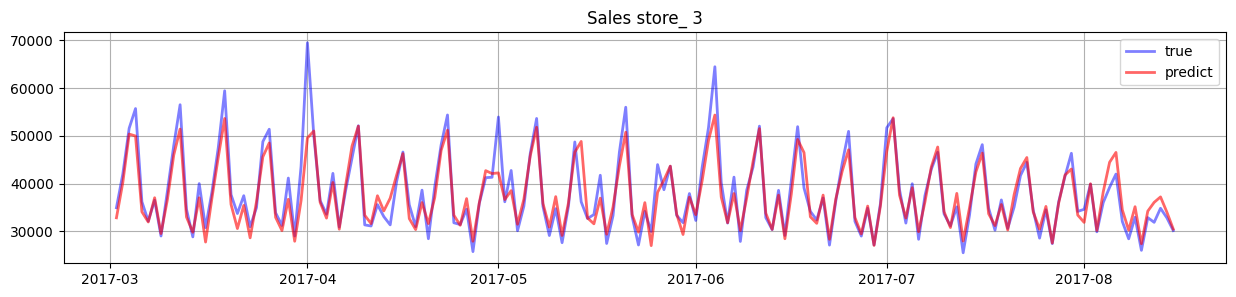

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(main_df_test_filtered['date'], main_df_test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
plt.plot(main_df_test_filtered['date'], y_pred, color="red", lw=2, label="predict", alpha=.6) 
plt.title("Sales store_ "+str(t))
plt.grid();
plt.legend();

Curva de Aprendizaje para la tienda seleccionada

In [ ]:
#Definición de función para realizar curva de aprendizaje 
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_log_error', train_sizes=np.linspace(0.1, 1.0, 12)
    )
    train_scores_mean = np.sqrt(-np.mean(train_scores,axis=1))
    test_scores_mean = np.sqrt(-np.mean(test_scores,axis=1))
    
    #plt.figure(figsize=(10 , 7.5))
   
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training error'  , color='r')
    plt.plot(train_sizes, test_scores_mean,  'o-', label='Validation error', color='g')
    plt.xlabel('Training Set Size')
    plt.ylabel('Root Mean Squared Logarithm Error')
    plt.title('Learning Curve store_'+str(t))
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

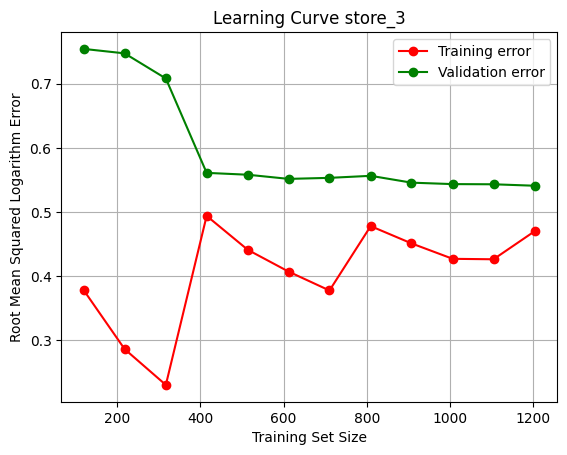

In [ ]:
plot_learning_curve(forecaster, Xtrain, Ytrain)

## Predicciones de Ventas de cada tienda

In [ ]:
tiendas = np.empty(55,dtype=object)
for i in range(1,55):
  #Creando Xtrain,Ytrain,Xtest,Ytest
  train_filtered = main_df_train[main_df_train['store_nbr']==i]
  test_filtered = main_df_test[main_df_test['store_nbr']==i]
  columns_serie = train_filtered.columns.values
  columns_serie = np.delete(columns_serie,[0,2]) #Deleted date and sales 
  Xtrain = train_filtered.loc[:,columns_serie].values
  Ytrain = train_filtered.loc[:,'sales'].values
  Xtest = test_filtered.loc[:,columns_serie].values
  Ytest = test_filtered.loc[:,'sales'].values

  #Crear nuevo modelo con los mejores hiperparametros
  forecaster = RandomForestRegressor(n_estimators = params_RF['n_estimator'], 
                                   max_features = params_RF['max_feature'], 
                                   max_depth = params_RF['max_depth'],
                                   min_samples_split= params_RF['min_samples_split'], 
                                   min_samples_leaf= params_RF['min_samples_leaf'], 
                                   random_state=10 )
  forecaster.fit(Xtrain, Ytrain)

  y_pred = forecaster.predict(Xtest)
  rmsle_test =(mean_squared_log_error(Ytest, y_pred ,squared=False))
  print("RMSLE tienda %d : %.3f"% (i,rmsle_test))

  tienda = {
      'tienda_id':i,
      'y_pred': y_pred,
      'rmsle':rmsle_test,
      'Xtrain':Xtrain
  }

  tiendas[i] = tienda

RMSLE tienda 1 : 0.103
RMSLE tienda 2 : 0.081
RMSLE tienda 3 : 0.072
RMSLE tienda 4 : 0.098
RMSLE tienda 5 : 0.085
RMSLE tienda 6 : 0.082
RMSLE tienda 7 : 0.082
RMSLE tienda 8 : 0.082
RMSLE tienda 9 : 0.104
RMSLE tienda 10 : 0.116
RMSLE tienda 11 : 0.088
RMSLE tienda 12 : 0.102
RMSLE tienda 13 : 0.102
RMSLE tienda 14 : 0.144
RMSLE tienda 15 : 0.087
RMSLE tienda 16 : 0.205
RMSLE tienda 17 : 0.096
RMSLE tienda 18 : 0.119
RMSLE tienda 19 : 0.099
RMSLE tienda 20 : 0.132
RMSLE tienda 21 : 0.148
RMSLE tienda 22 : 0.132
RMSLE tienda 23 : 0.095
RMSLE tienda 24 : 0.085
RMSLE tienda 25 : 0.124
RMSLE tienda 26 : 0.169
RMSLE tienda 27 : 0.083
RMSLE tienda 28 : 0.109
RMSLE tienda 29 : 0.096
RMSLE tienda 30 : 0.246
RMSLE tienda 31 : 0.123
RMSLE tienda 32 : 0.345
RMSLE tienda 33 : 0.137
RMSLE tienda 34 : 0.075
RMSLE tienda 35 : 0.109
RMSLE tienda 36 : 0.101
RMSLE tienda 37 : 0.099
RMSLE tienda 38 : 0.131
RMSLE tienda 39 : 0.145
RMSLE tienda 40 : 0.156
RMSLE tienda 41 : 0.141
RMSLE tienda 42 : 0.108
R

In [ ]:
# Grafica
fig, axes = plt.subplots(18, 3, figsize = (20,50))
for i in range(1,55):
  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  test_filtered = main_df_test[main_df_test['store_nbr']==i]
  #Grafica
  ax.plot(test_filtered['date'], test_filtered['sales'], color="blue", lw=2, label="true", alpha=.5)
  ax.plot(test_filtered['date'], tiendas[i]['y_pred'], color="red", lw=2, label="predict", alpha=.6)
  ax.set_title("Sales Store "+ str(i))
  ax.legend(loc='best')
  ax.grid()
  
plt.legend()
plt.tight_layout(pad=3)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Curvas de Aprendizaje de cada Tienda
Se evalúa la curva de aprendizaje para todas las tiendas. <br>
Debido al costo computacional, la ejecución de la siguiente celda de código tarda alrededor de 20 minutos

Procesando tienda 54

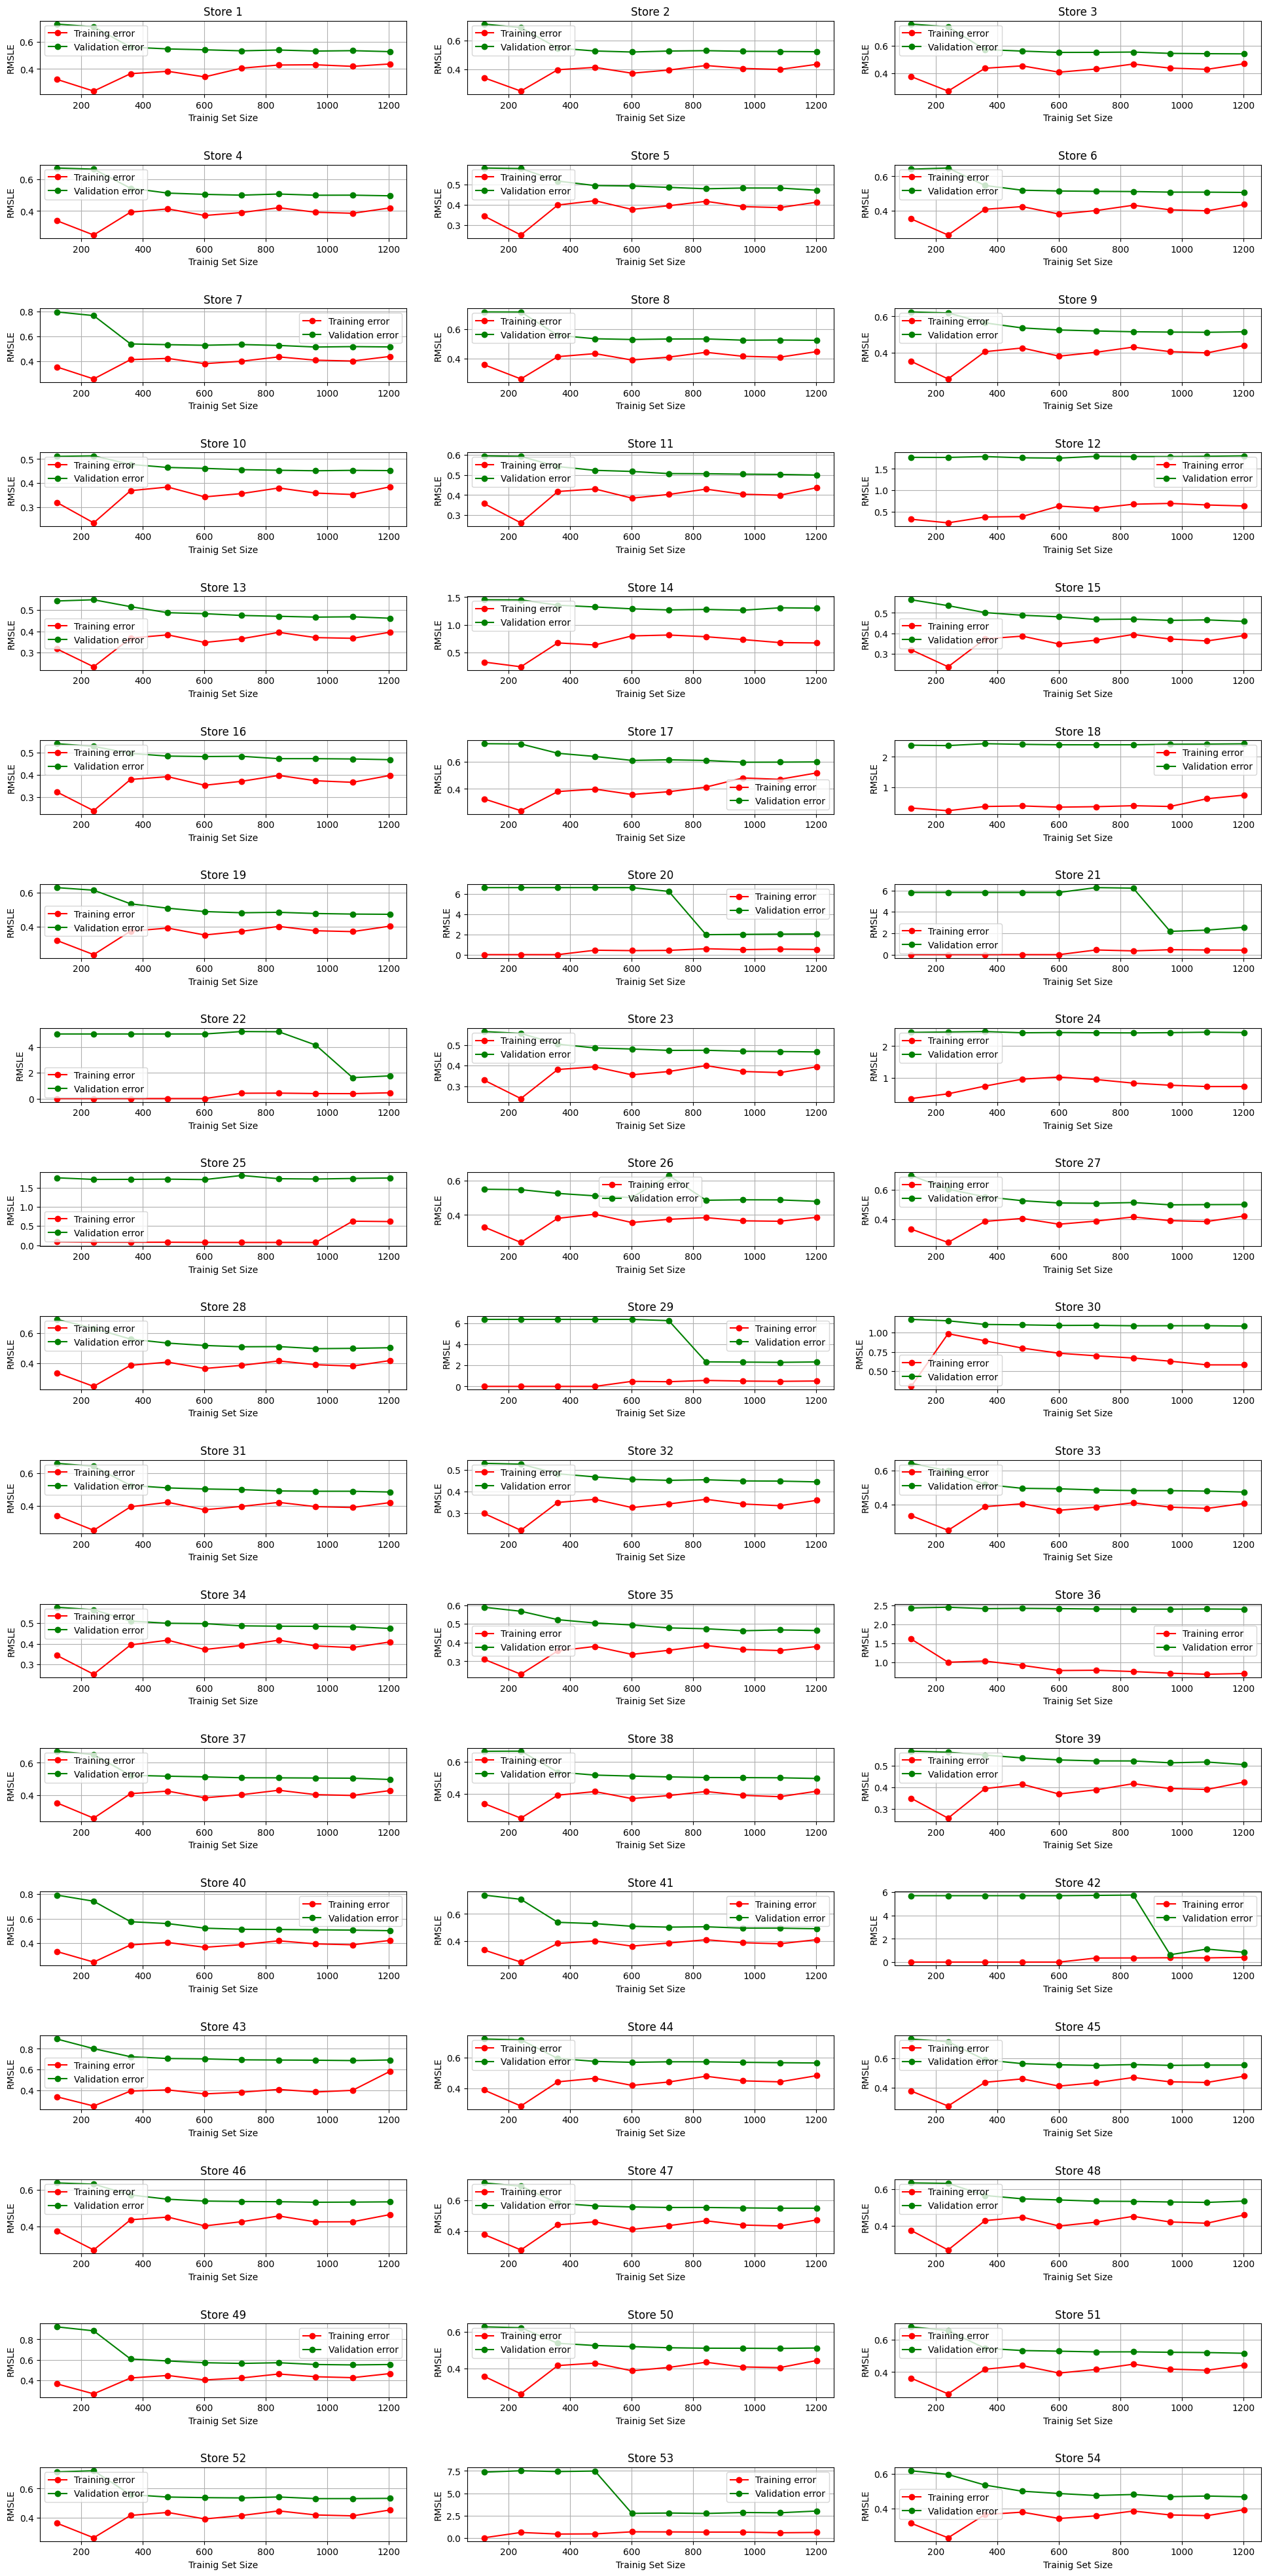

In [ ]:
#Código para generar la curva de aprendizaje de todas la tienda. 
fig, axes = plt.subplots(18, 3, figsize = (20,40)) 
for i in range(1,55):
  
  mensaje = ("Procesando tienda "+ str(i))
  sys.stdout.write('\r'+mensaje)

  #Calcular posicion de la grafica
  row, col = divmod(i - 1, 3)
  ax = axes[row, col]
  #filtrar tienda
  train_filtered = main_df_train[main_df_train['store_nbr']==i]

  #plot_learning_curve()
  train_sizes, train_scores, test_scores = learning_curve(
      forecaster, tiendas[i]['Xtrain'], train_filtered['sales'], cv=5, scoring='neg_mean_squared_log_error', train_sizes=np.linspace(0.1, 1.0, 10)
  )
  #promedio de los score para trian y test
  train_scores_mean = np.sqrt(-np.mean(train_scores,axis=1))
  test_scores_mean = np.sqrt(-np.mean(test_scores,axis=1))

 
  ax.plot(train_sizes, train_scores_mean, 'o-', label='Training error'  , color='r')
  ax.plot(train_sizes, test_scores_mean,  'o-', label='Validation error', color='g')

  ax.set_title('Store ' + str(i))
  ax.legend(loc='best')
  ax.grid(True)

  for ax in axes.flat:
    ax.set(xlabel='Trainig Set Size', ylabel='RMSLE')

plt.tight_layout(pad=3)
plt.show()

# Conclusiones

Text(0, 0.5, 'RMSLE en test')

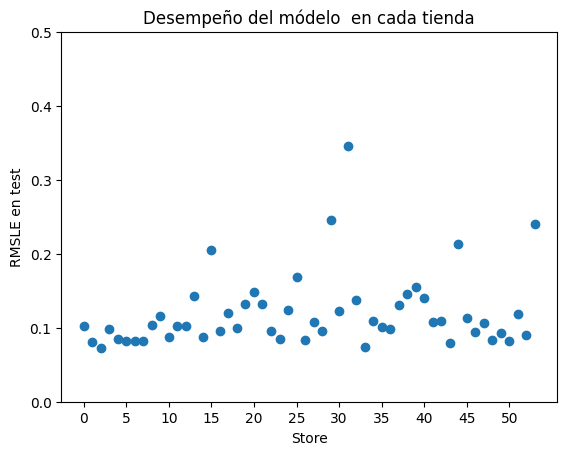

In [ ]:
store_id=np.arange(1,55)
scores_tienda=np.zeros(55)
for i in store_id:
  scores_tienda[i]=tiendas[i]['rmsle']
scores_tienda=scores_tienda[1:]
plt.scatter(np.arange(len(scores_tienda)),scores_tienda)
plt.ylim([0, 0.5])
plt.xticks(np.arange(0,55,5))
plt.title('Desempeño del módelo  en cada tienda')
plt.xlabel("Store")
plt.ylabel("RMSLE en test")

In [ ]:
print('RSMLE max=', "%.4f" % max(scores_tienda))
print('RSMLE min=', "%.4f" % min(scores_tienda))
print('RSMLE promedio=', "%.4f" % np.mean(scores_tienda))

RSMLE max= 0.3454
RSMLE min= 0.0721
RSMLE promedio= 0.1197
